In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.utils import resample
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
df = pd.read_csv('data/rideshare_kaggle.csv')
df.head()

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,...,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime
0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1.544953e+09,9,16,12,2018-12-16 09:30:07,America/New_York,Haymarket Square,North Station,Lyft,...,0.1276,1544979600,39.89,1545012000,43.68,1544968800,33.73,1545012000,38.07,1544958000
1,4bd23055-6827-41c6-b23b-3c491f24e74d,1.543284e+09,2,27,11,2018-11-27 02:00:23,America/New_York,Haymarket Square,North Station,Lyft,...,0.1300,1543251600,40.49,1543233600,47.30,1543251600,36.20,1543291200,43.92,1543251600
2,981a3613-77af-4620-a42a-0c0866077d1e,1.543367e+09,1,28,11,2018-11-28 01:00:22,America/New_York,Haymarket Square,North Station,Lyft,...,0.1064,1543338000,35.36,1543377600,47.55,1543320000,31.04,1543377600,44.12,1543320000
3,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,1.543554e+09,4,30,11,2018-11-30 04:53:02,America/New_York,Haymarket Square,North Station,Lyft,...,0.0000,1543507200,34.67,1543550400,45.03,1543510800,30.30,1543550400,38.53,1543510800
4,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,1.543463e+09,3,29,11,2018-11-29 03:49:20,America/New_York,Haymarket Square,North Station,Lyft,...,0.0001,1543420800,33.10,1543402800,42.18,1543420800,29.11,1543392000,35.75,1543420800


In [4]:
# General info
df.info()

# Quick preview
df.head()

# Shape
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

# Check for missing values
df.isna().sum()

# Check for duplicates
df.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 693071 entries, 0 to 693070
Data columns (total 57 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           693071 non-null  object 
 1   timestamp                    693071 non-null  float64
 2   hour                         693071 non-null  int64  
 3   day                          693071 non-null  int64  
 4   month                        693071 non-null  int64  
 5   datetime                     693071 non-null  object 
 6   timezone                     693071 non-null  object 
 7   source                       693071 non-null  object 
 8   destination                  693071 non-null  object 
 9   cab_type                     693071 non-null  object 
 10  product_id                   693071 non-null  object 
 11  name                         693071 non-null  object 
 12  price                        637976 non-null  float64
 13 

0

In [5]:
# number of missing values
df.isna().sum().sort_values(ascending=False).head()

price                      55095
id                             0
ozone                          0
temperatureLowTime             0
apparentTemperatureHigh        0
dtype: int64

/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


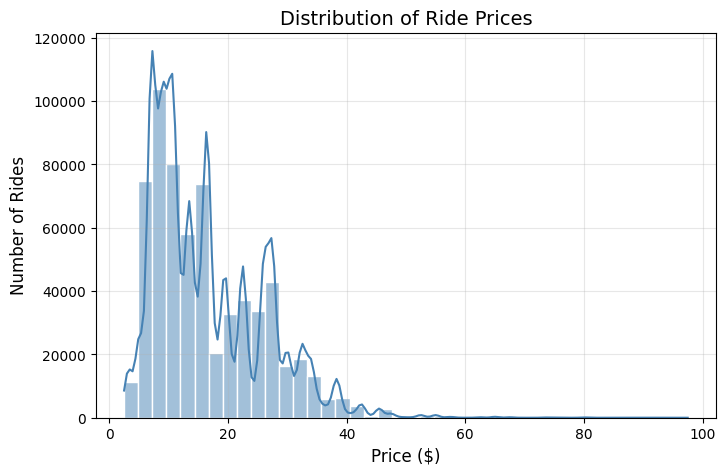

In [6]:
prices = df['price'].dropna()

plt.figure(figsize=(8,5))
sns.histplot(prices, bins=40, kde=True, color='steelblue', edgecolor='white')

plt.title('Distribution of Ride Prices', fontsize=14)
plt.xlabel('Price ($)', fontsize=12)
plt.ylabel('Number of Rides', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

/Users/macbook/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


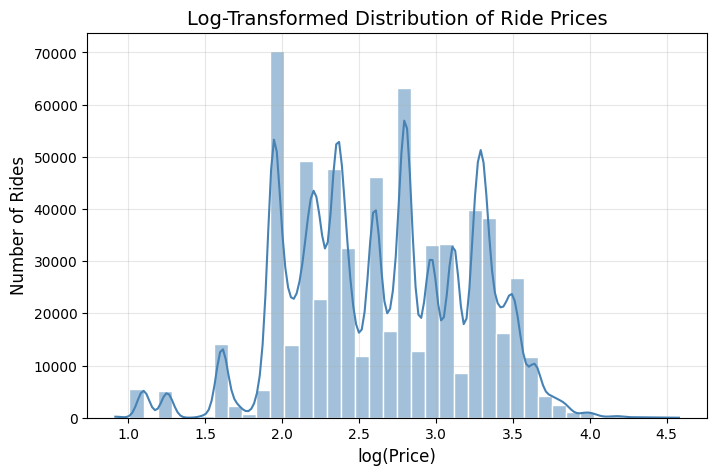

In [7]:
# Use np.log1p() to handle any zero or near-zero prices safely
prices = np.log(df['price'].dropna())

plt.figure(figsize=(8,5))
sns.histplot(prices, bins=40, kde=True, color='steelblue', edgecolor='white')

plt.title('Log-Transformed Distribution of Ride Prices', fontsize=14)
plt.xlabel('log(Price)', fontsize=12)
plt.ylabel('Number of Rides', fontsize=12)
plt.grid(alpha=0.3)
plt.show()

In [8]:
print(df['cab_type'].value_counts())
print(df['cab_type'].value_counts(normalize=True))

cab_type
Uber    385663
Lyft    307408
Name: count, dtype: int64
cab_type
Uber    0.556455
Lyft    0.443545
Name: proportion, dtype: float64


In [9]:
df['name'].value_counts().head()

name
UberXL       55096
WAV          55096
Black SUV    55096
Black        55095
Taxi         55095
Name: count, dtype: int64

In [10]:
df['surge_multiplier'].value_counts()

surge_multiplier
1.00    672096
1.25     11085
1.50      5065
1.75      2420
2.00      2239
2.50       154
3.00        12
Name: count, dtype: int64

In [11]:
# Numeric columns summary
df.describe().T

# Categorical columns summary
df.describe(include='object').T

,count,unique,top,freq
id,693071,693071,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,1
datetime,693071,31350,2018-11-26 23:21:14,156
timezone,693071,1,America/New_York,693071
source,693071,12,Financial District,58857
destination,693071,12,Financial District,58851
cab_type,693071,2,Uber,385663
product_id,693071,13,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,55096
name,693071,13,UberXL,55096
short_summary,693071,9,Overcast,218895
long_summary,693071,11,Mostly cloudy throughout the day.,202340


In [12]:
# Count of unique values for each column
df.nunique().sort_values(ascending=False)

id                             693071
timestamp                       36179
datetime                        31350
distance                          549
apparentTemperature               319
pressure                          316
dewPoint                          313
temperature                       308
windSpeed                         291
windGust                          286
ozone                             274
visibility.1                      227
visibility                        227
windBearing                       195
price                             147
apparentTemperatureMin            137
apparentTemperatureLow            136
temperatureLow                    133
temperatureMin                    131
temperatureHigh                   129
temperatureMax                    128
apparentTemperatureMax            125
apparentTemperatureHigh           124
sunsetTime                        114
sunriseTime                       110
cloudCover                         83
precipIntens

In [ ]:
# Numerical variables EDA
num_cols = [
    'distance', 'surge_multiplier',
    'temperature', 'precipIntensity', 'precipProbability',
    'cloudCover', 'hour','month'
]

df_num = df[num_cols].copy()

df_num.head()

,distance,surge_multiplier,temperature,precipIntensity,precipProbability,cloudCover,hour,month
0,0.44,1.0,42.34,0.0000,0.0,0.72,9,12
1,0.44,1.0,43.58,0.1299,1.0,1.00,2,11
2,0.44,1.0,38.33,0.0000,0.0,0.03,1,11
3,0.44,1.0,34.38,0.0000,0.0,0.00,4,11
4,0.44,1.0,37.44,0.0000,0.0,0.44,3,11


In [15]:
summary = df_num.describe().T
summary['skew'] = df_num.skew()
summary['kurtosis'] = df_num.kurtosis()
summary

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
distance,693071.0,2.189430,1.138937,0.02,1.28,2.16,2.92,7.8600,0.834395,1.228018
surge_multiplier,693071.0,1.013870,0.091641,1.00,1.00,1.00,1.00,3.0000,8.320248,80.534605
temperature,693071.0,39.584388,6.726084,18.91,36.45,40.49,43.58,57.2200,-0.609040,0.759519
precipIntensity,693071.0,0.008922,0.026901,0.00,0.00,0.00,0.00,0.1447,3.325536,10.375605
precipProbability,693071.0,0.146076,0.328938,0.00,0.00,0.00,0.00,1.0000,2.027870,2.335140
cloudCover,693071.0,0.686502,0.358534,0.00,0.37,0.82,1.00,1.0000,-0.733130,-0.998378
hour,693071.0,11.619137,6.948114,0.00,6.00,12.00,18.00,23.0000,-0.045432,-1.181227
month,693071.0,11.586684,0.492429,11.00,11.00,12.00,12.00,12.0000,-0.352070,-1.876052


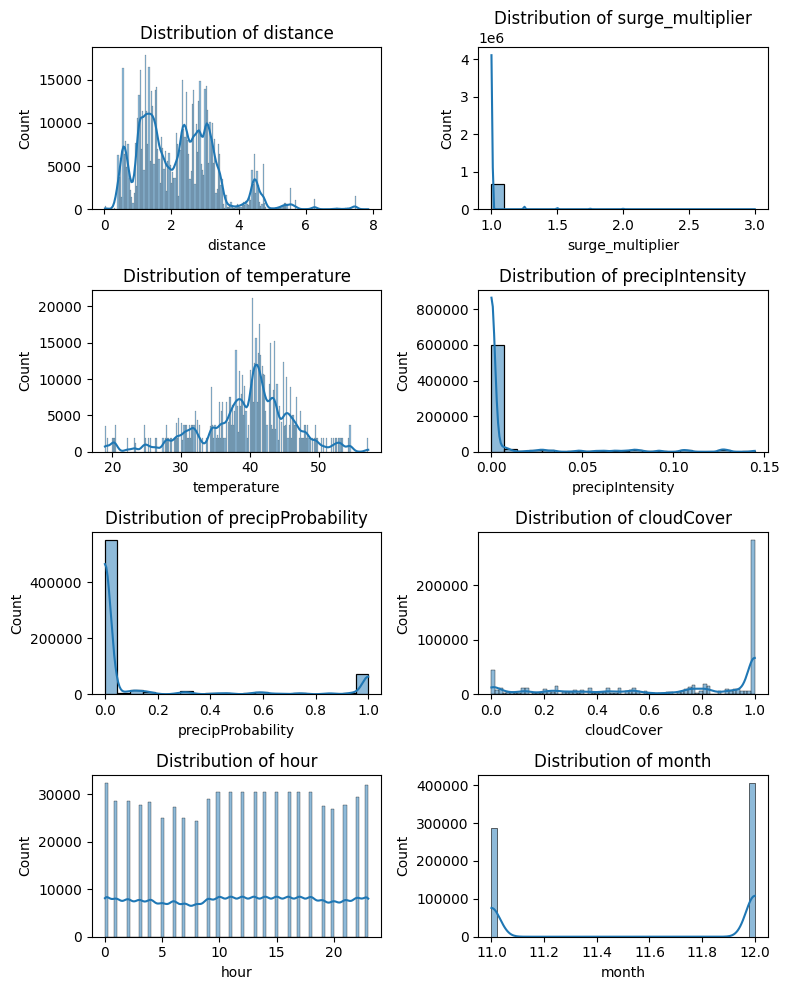

In [ ]:
# Distribution Plots of predictors
plt.figure(figsize=(8, 10))

for i, col in enumerate(num_cols):
    plt.subplot(4, 2, i+1)
    sns.histplot(df_num[col], kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [22]:
# Outlier detection
outlier_summary = {}

for col in num_cols:
    Q1 = df_num[col].quantile(0.25)
    Q3 = df_num[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    outliers = ((df_num[col] < lower) | (df_num[col] > upper)).sum()
    outlier_summary[col] = outliers

pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count'])

,Outlier Count
distance,8662
surge_multiplier,20975
temperature,36659
precipIntensity,150828
precipProbability,150828
cloudCover,0
hour,0
month,0


In [25]:
# Scalling
scaler = StandardScaler()
scaled = scaler.fit_transform(df_num)

scaled_df = pd.DataFrame(scaled, columns=[c + '_scaled' for c in num_cols])
scaled_df.head()

,distance_scaled,surge_multiplier_scaled,temperature_scaled,precipIntensity_scaled,precipProbability_scaled,cloudCover_scaled,hour_scaled,month_scaled
0,-1.536021,-0.151349,0.409691,-0.331672,-0.444083,0.093430,-0.376957,0.839341
1,-1.536021,-0.151349,0.594048,4.497229,2.596003,0.874388,-1.384425,-1.191411
2,-1.536021,-0.151349,-0.186496,-0.331672,-0.444083,-1.831073,-1.528349,-1.191411
3,-1.536021,-0.151349,-0.773763,-0.331672,-0.444083,-1.914747,-1.096577,-1.191411
4,-1.536021,-0.151349,-0.318817,-0.331672,-0.444083,-0.687527,-1.240501,-1.191411


The numerical predictors in our dataset exhibit a wide range of distributional behaviors. Distance shows a multimodal distribution reflecting different ride types (short local
trips vs. longer airport rides), while surge_multiplier is highly concentrated at 1.0, indicating that the vast majority of rides occur without surge pricing. Weather variables, especially precipIntensity and precipProbability, are extremely right-skewed, with over 150,000 outliers each, reflecting the rarity of heavy precipitation events.
Temperature is moderately distributed and cloudCover is nearly uniform, making both well-behaved predictors. Hour is uniformly distributed, while month shows almost no
variation, suggesting limited temporal coverage in the dataset. All predictors were standardized.
